# Random Forests in trading 

In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
import re

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

## import model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

## Definitions for indicators

In [2]:
# Calculate the Relative Strength Index

def RSI(df, n = 14):
    
    df['change_in_price'] = df['Close'].diff()

    # First make a copy of the data frame twice
    up_df, down_df = df[['change_in_price']].copy(), df[['change_in_price']].copy()
    
    # For up days, if the change is less than 0 set to 0.
    up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
    
    # For down days, if the change is greater than 0 set to 0.
    down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0
    
    # We need change in price to be absolute.
    down_df['change_in_price'] = down_df['change_in_price'].abs()
    
    # Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
    ewma_up = up_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
    ewma_down = down_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
    
    # Calculate the Relative Strength
    relative_strength = ewma_up / ewma_down
    
    # Calculate the Relative Strength Index
    relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))
    
    # Add the info to the data frame.
    RSI = pd.Series(relative_strength_index, name='RSI_' + str(n))
    return RSI

In [3]:
# Calculate the Stochastic Oscillator %K
def STOK(df, n = 14):
    
    # Make a copy of the high and low column.
    low_n, high_n = df[['Low']].copy(), df[['High']].copy()
    
    # Apply the rolling function and grab the Min and Max.
    low_n = low_n['Low'].transform(lambda x: x.rolling(window = n).min())
    high_n = high_n['High'].transform(lambda x: x.rolling(window = n).max())
    
    # Calculate the Stochastic Oscillator.
    k_percent = 100 * ((df['Close'] - low_n) / (high_n - low_n))
    
    # Add the info to the data frame.
    KPercent = pd.Series(k_percent, name= '%K_' + str(n))
    return KPercent

In [4]:
# Calculate the Williams %R
def r_percent(df, n = 14):
    
    # Make a copy of the high and low column.
    low_n, high_n = df[['Low']].copy(), df[['High']].copy()
    
    # Group by symbol, then apply the rolling function and grab the Min and Max.
    low_n = low_n['Low'].transform(lambda x: x.rolling(window = n).min())
    high_n = high_n['High'].transform(lambda x: x.rolling(window = n).max())
    
    # Calculate William %R indicator.
    r_percent = -100 * ((high_n - df['Close']) / (high_n - low_n))

    RPercent = pd.Series(r_percent, name = '%R_' + str(n))

    return RPercent

In [5]:
# Calculate Exponential Moving Average

def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

#dataset['EMA10'] = EMA(dataset, 10)
#dataset['EMA30'] = EMA(dataset, 30)
#dataset['EMA200'] = EMA(dataset, 200)

In [6]:
# Calculate the Moving Average Convergence Divergence
def MACD(df):
    ema_26 = df['Close'].transform(lambda x: x.ewm(span = 26).mean())
    ema_12 = df ['Close'].transform(lambda x: x.ewm(span = 12).mean())
    macd = ema_12 - ema_26
    
    # Calculate the EMA
    ema_9_macd = macd.ewm(span = 9).mean()
    
    # Store the data in the data frame.
    df['MACD'] = macd
    df['MACD_EMA'] = ema_9_macd # signal line

    return df

In [7]:
# Calculate the Price Rate of change
def ROC(df, n):
    ROC = pd.Series(df['Close'].transform(lambda x: x.pct_change(periods = n)), name = 'ROC_' + str(n)) 
    return ROC

In [8]:
#Calculate the price momentum
def MOM(df, n):   
    MOM = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))   
    return MOM
#dataset['MOM10'] = MOM(dataset['Close'], 10)
#dataset['MOM30'] = MOM(dataset['Close'], 30)

In [9]:
# Calculate the On Balance Volume

def OBV(df):
    volume = df['Volume'].copy()
    change = df['Close'].copy()
    
    #print(volume)
    
    # Initialize the previous OBV
    prev_obv = 0
    obv_values = []
    
    for i, j in zip(change, volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
    
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    df['OBV'] = pd.Series(obv_values, index = df.index)
    return df

## Create prediction classes (1 for up, 0 for down)

In [10]:
def prediction_class(df):
    df['Prediction'] = np.where(df['Close'] < df['Close'].shift(-1), 1, 0)
    return df

## Import data from yfinance

In [11]:
Company = ['Apple', 'Oil', 'Ford']
ticker = ['AAPL', 'CL=F', 'F']

In [12]:
Apple = yf.download('AAPL', start = '2020-03-23', end = '2024-10-11')
Oil = yf.download('CL=F', start = '2020-03-23', end = '2024-10-11')
Ford = yf.download('F', start = '2020-03-23', end = '2024-10-11')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
# dropped_columns: columns that we don't use in our prediction
dropped_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [14]:
Apple['RSI10'] = RSI(Apple, 10)
Apple['RSI30'] = RSI(Apple, 30)
Apple['RSI200'] = RSI(Apple, 200)

Apple['%K10'] = STOK(Apple, 10)
Apple['%K30'] = STOK(Apple, 30)
Apple['%K200'] = STOK(Apple, 200)

Apple['%R10'] = r_percent(Apple, 10)
Apple['%R30'] = r_percent(Apple, 30)
Apple['%R200'] = r_percent(Apple, 200)

Apple['MOM10'] = MOM(Apple, 10)
Apple['MOM30'] = MOM(Apple, 30)
Apple['MOM200'] = MOM(Apple, 200)

Apple['ROC10'] = ROC(Apple, 10)
Apple['ROC30'] = ROC(Apple, 30)
Apple['ROC200'] = ROC(Apple, 200)

MACD(Apple)
OBV(Apple)
prediction_class(Apple)

#for col in Apple.columns:
#    Apple.rename(columns={col: 'Apple' + str(col)}, inplace=True)

Apple

,Open,High,Low,Close,Adj Close,Volume,change_in_price,RSI10,RSI30,RSI200,...,MOM10,MOM30,MOM200,ROC10,ROC30,ROC200,MACD,MACD_EMA,OBV,Prediction
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-23,57.020000,57.125000,53.152500,56.092499,54.569729,336752800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,336752800,1
2020-03-24,59.090000,61.922501,58.575001,61.720001,60.044464,287531200,5.627502,100.000000,100.000000,100.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.126258,0.070143,624284000,0
2020-03-25,62.687500,64.562500,61.075001,61.380001,59.713696,303602000,-0.340000,93.123420,93.933376,94.248503,...,NaN,NaN,NaN,NaN,NaN,NaN,0.150334,0.103009,927886000,1
2020-03-26,61.630001,64.669998,61.590000,64.610001,62.855991,252087200,3.230000,96.176379,96.246077,96.293860,...,NaN,NaN,NaN,NaN,NaN,NaN,0.274218,0.161006,1179973200,0
2020-03-27,63.187500,63.967499,61.762501,61.935001,60.253624,204216800,-2.674999,66.356623,71.960373,74.216278,...,NaN,NaN,NaN,NaN,NaN,NaN,0.229318,0.181328,1384190000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-04,227.899994,228.000000,224.130005,226.800003,226.800003,37245100,1.130005,50.534649,53.147237,55.401854,...,-1.399994,2.270004,30.910004,-0.006135,0.010110,0.157793,1.324742,1.291114,100824500100,0
2024-10-07,224.500000,225.690002,221.330002,221.690002,221.690002,39505400,-5.110001,32.952519,45.777752,54.117210,...,-4.779999,-5.149994,24.750000,-0.021107,-0.022703,0.125673,0.843553,1.201602,100864005500,1
2024-10-08,224.300003,225.979996,223.250000,225.770004,225.770004,31855700,4.080002,49.946825,51.515748,54.959467,...,-1.599991,-1.409988,30.940002,-0.007037,-0.006206,0.158805,0.782411,1.117764,100895861200,1


In [15]:
Apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1147 entries, 2020-03-23 to 2024-10-10
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             1147 non-null   float64
 1   High             1147 non-null   float64
 2   Low              1147 non-null   float64
 3   Close            1147 non-null   float64
 4   Adj Close        1147 non-null   float64
 5   Volume           1147 non-null   int64  
 6   change_in_price  1146 non-null   float64
 7   RSI10            1146 non-null   float64
 8   RSI30            1146 non-null   float64
 9   RSI200           1146 non-null   float64
 10  %K10             1138 non-null   float64
 11  %K30             1118 non-null   float64
 12  %K200            948 non-null    float64
 13  %R10             1138 non-null   float64
 14  %R30             1118 non-null   float64
 15  %R200            948 non-null    float64
 16  MOM10            1137 non-null   float64
 

In [16]:
Apple = Apple.drop(dropped_columns, axis = 1)
Apple = Apple.dropna()
Apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 947 entries, 2021-01-06 to 2024-10-10
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   change_in_price  947 non-null    float64
 1   RSI10            947 non-null    float64
 2   RSI30            947 non-null    float64
 3   RSI200           947 non-null    float64
 4   %K10             947 non-null    float64
 5   %K30             947 non-null    float64
 6   %K200            947 non-null    float64
 7   %R10             947 non-null    float64
 8   %R30             947 non-null    float64
 9   %R200            947 non-null    float64
 10  MOM10            947 non-null    float64
 11  MOM30            947 non-null    float64
 12  MOM200           947 non-null    float64
 13  ROC10            947 non-null    float64
 14  ROC30            947 non-null    float64
 15  ROC200           947 non-null    float64
 16  MACD             947 non-null    float64
 1

## Correlation matrix

<Axes: title={'center': 'Apple Correlation Matrix'}>

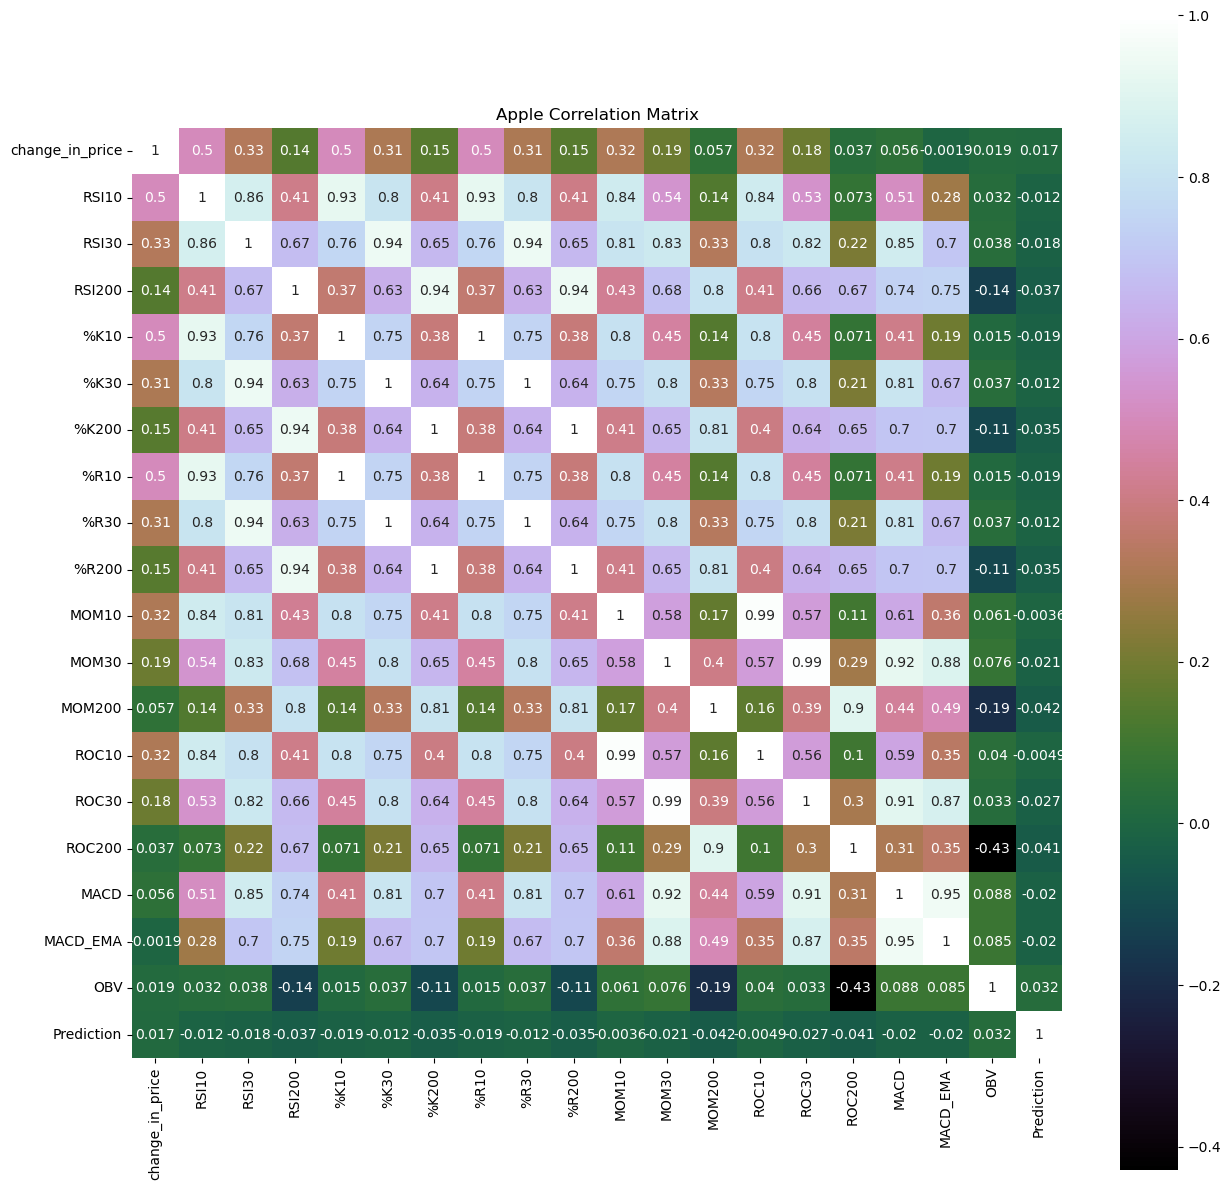

In [28]:
correlation = Apple.corr()
plt.figure(figsize=(15,15))
plt.title('Apple Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

### Decision Tree and RF

In [22]:
tree = DecisionTreeClassifier(
    #max_depth = 10, 
    min_samples_leaf = 5, # minimum number of samples in each leaf, to prevent overfitting
    random_state= 216)

rf = RandomForestClassifier(
    n_estimators = 500, # number of trees in ensemble
    #max_depth = 10, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 2, # default is round(sqrt(num_features)), which in this case is 1.
    bootstrap= True, # sampling with replacement
    max_samples = 500, # number of training samples selected with replacement to build tree
    random_state = 216 # for consistency
    )

rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

In [23]:
Y = Apple['Prediction']
X = Apple.loc[:, Apple.columns != 'Prediction']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1)

In [26]:
## Fit the models
tree.fit(X_train, Y_train)
print(accuracy_score(Y_test, tree.predict(X_test)))

## rf and et may take slightly longer because we are fitting many trees
rf.fit(X_train, Y_train)
print(accuracy_score(Y_test, rf.predict(X_test)))

rand_frst_clf.fit(X_train, Y_train)
print(accuracy_score(Y_test, rand_frst_clf.predict(X_test)))

0.5210526315789473
0.5368421052631579
0.6


## Feature Importance

We can plot a chart on how much does each feature add to the total. That way, we can see how much each feature is contributing to the overall importance. Another standard graph that is used is a bar chart.

In [33]:
feature_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_imp

OBV                0.060919
change_in_price    0.060821
MOM10              0.055063
RSI10              0.054387
ROC200             0.053810
MACD_EMA           0.053749
%K10               0.052924
ROC30              0.052662
ROC10              0.052532
%K30               0.052219
RSI30              0.051727
RSI200             0.051653
MOM200             0.051364
MACD               0.051128
%R30               0.050375
%R10               0.050070
%K200              0.048636
MOM30              0.048523
%R200              0.047438
dtype: float64

In [32]:
feature_imp_1 = pd.Series(rand_frst_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_imp_1

change_in_price    0.071725
OBV                0.060541
ROC10              0.057107
RSI10              0.056500
ROC200             0.054865
MACD_EMA           0.054470
MOM10              0.054414
MOM200             0.054277
%R10               0.053661
ROC30              0.052408
%K10               0.050724
RSI30              0.050410
MOM30              0.049511
%K30               0.049456
RSI200             0.047791
MACD               0.047388
%R200              0.047235
%R30               0.043966
%K200              0.043551
dtype: float64

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

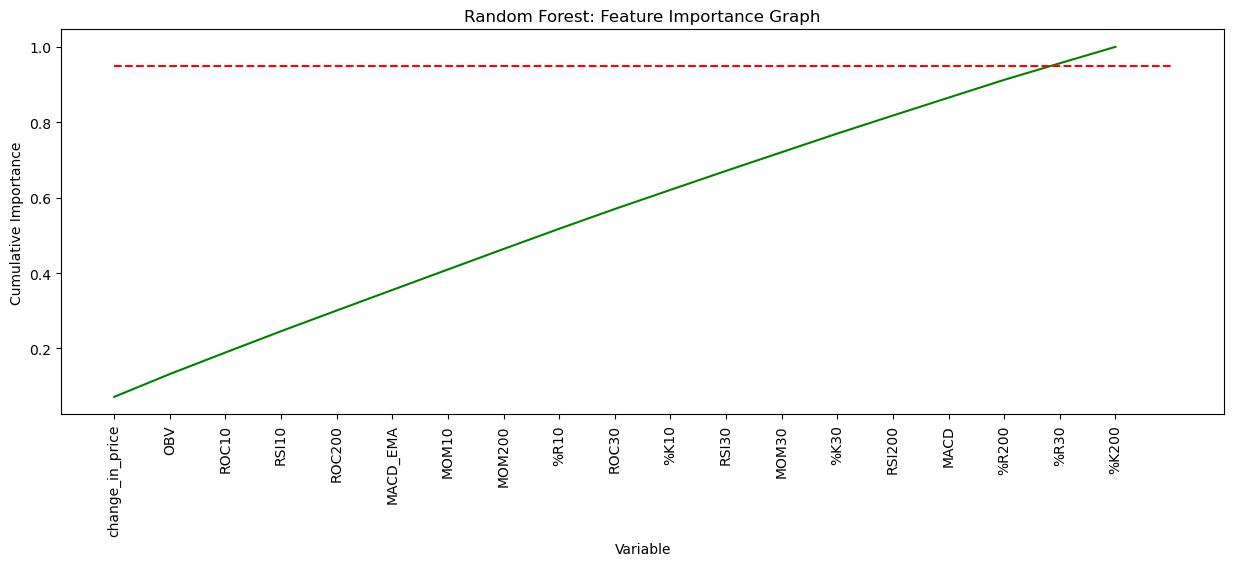

In [37]:
# store the values in a list to plot.
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp_1.values)

# Make a line graph
plt.figure(figsize=(15,5))
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp_1.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

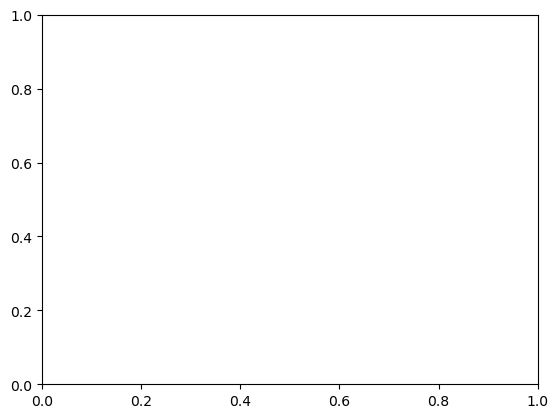

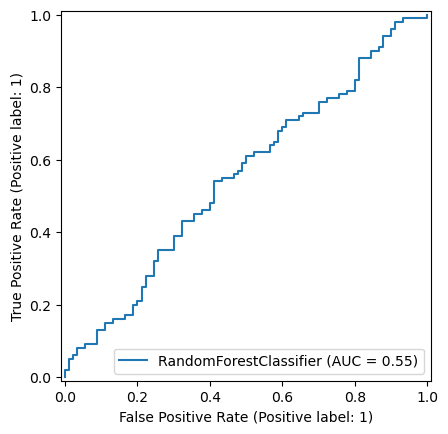

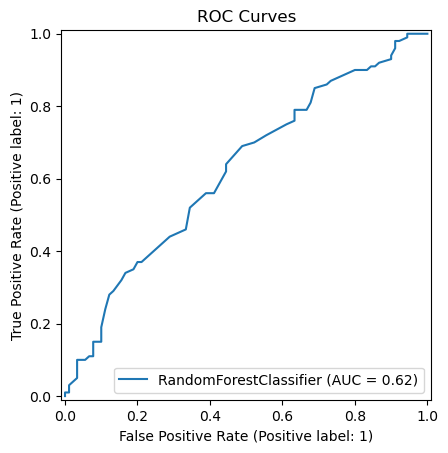

In [49]:
# Create an ROC Curve plot.
fig, ax = plt.subplots()
#plt.figure(figsize=(15, 5))
disp = RocCurveDisplay.from_estimator(rf, X_test, Y_test)
disp_1 = RocCurveDisplay.from_estimator(rand_frst_clf, X_test, Y_test)
#ax.plot(rfc_disp, label = 'RF')
#ax.plot(rfc_disp_1, label = 'Gini RF')
plt.title("ROC Curves")
plt.show()
